## Hello! Welcome to the magical world of MCMC.

In [3]:
#These are some imports

import numpy as np
import matplotlib.pyplot as plt #Don't trust Feeney on this
import emcee #actually optional
%matplotlib inline

The simplest MCMC code requires three pieces:

- A likelihood function + priors, to evaluate the probability density at a given point
- A proposal density to decide where to go next
- Some criterion to decide whether the step is accepted or rejected.

In [1]:
#Let's start with a 1D likelihood function and forget priors for a moment. 

def l(x, mu, var):
   return 1/np.sqrt(2*np.pi*var)*np.exp(-(x-mu)**2/(2*var))

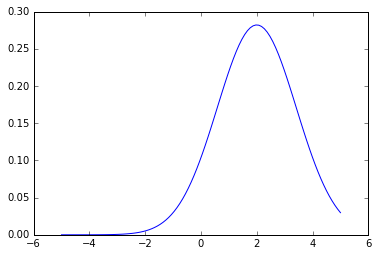

In [4]:
#We can plot it to make sure it looks good.
points = np.linspace(-5,5,100)
plt.plot(points,l(points,2,2))

In [5]:
#Next we need the proposal density. Let's make it a Gaussian with mean x and standard dev. sigma

def tryone(x,sigma):
    return x + sigma * np.random.randn()

Ok, let's now build a Metropolis-Hastings algorithm. Here is the pseudocode: 

1. Initialize the value of the independent variable x at some sensible location, i.e. 0
2. If necessary, initialize the object that will contain the steps (i.e. a list or array)
3. Repeat nsteps times:

   3a. Generate r = uniform random number between 0 and 1 (can use np.random.rand() function) 
   
   3b. Generate new point y starting from x, using proposal density above with sigma = 1.
   
   3c. Calculate p(y) and p(x), using the likelihood function we defined, with mu = 2, var = 2. Priors would enter here
   
   3c. If prob(y)/prob(x) > r, accept step and update current location; otherwise reject
   
   3d. Add point to chain 
   
  

In [66]:
#Incidentally, this is problem 2 in Hogg&DFM's paper

x = 0
accept = 0
samples = []
for n in range(10000):
    rando = np.random.rand()
    y = tryone(x,5) #increasing sigma in the proposal density gives better acceptance rates
    if l(y,2,2)/l(x,2,2) > rando:
        x = y
        accept+=1
    samples.append(x)
print('accept % =', accept/len(samples))

accept % = 0.3227


Plot the distribution and the samples - rejoice!

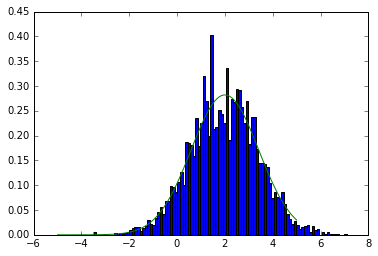

In [12]:
plt.hist(samples, bins=100, normed=True)
plt.plot(points,l(points,2,2))

In [13]:
#Problem 3 in Hogg&DFM's paper - just leaving it here

def unifl(x):
    return np.heaviside(x-3, 1)*np.heaviside(7-x, 1)/4.

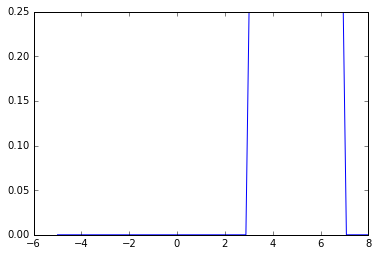

In [14]:
x = np.linspace(-5,8,100)
plt.plot(x,unifl(x))

In [15]:
x = 0
accept = 0
samples = []
for n in range(10000):
    rando = np.random.rand()
    y = tryone(x,1)
    if unifl(y)/unifl(x) > rando:
        x = y
        accept+=1
    samples.append(x)
print('accept % =', accept/len(samples))

accept % = 0.8051


/Users/vivi/anaconda/lib/python3.4/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/vivi/anaconda/lib/python3.4/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


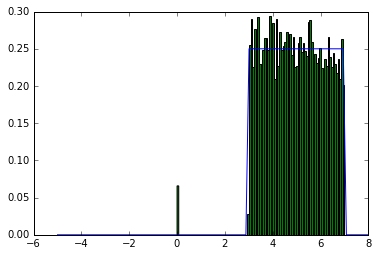

In [16]:
points = np.linspace(-5,8,100)
plt.plot(points,unifl(points));
plt.hist(samples,bins=100,normed=True);

In [17]:
#Let's now use loglike instead of like, and add priors

def ln_like(x, mu, var): #Note: mu and var here take place of "data/errors" in real world problems
    return np.log(1/np.sqrt(2*np.pi*var)) + (-(x-mu)**2/(2*var))

In [18]:
def ln_priors(x, xlo = 0, xhi =4): #These are flat and proper (limited)
    if xlo <= x <= xhi:
        return 0
    else:
        return - np.inf

Note: this is different from using ln(x) as sampling variable!

We can combine ln_like and ln_priors to sample from the posterior.

In [20]:
x = 0
accept = 0
samples = []
for n in range(10000):
    rando = np.random.rand()
    y = tryone(x,4)
    if ln_like(y,2,2) + ln_priors(y) \
        - ln_like(x,2,2) - ln_priors(x) > np.log(rando):
        x = y
        accept+=1
    samples.append(x)
print('accept % =', accept/len(samples))

accept % = 0.3133


Let's take a look at the samples.

(-1, 5)

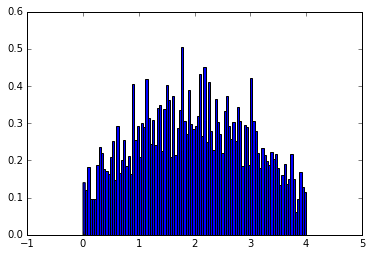

In [25]:
plt.hist(samples,bins = 100, normed=True);
plt.xlim(-1,5)

Let's move on to > 1 dimension and write a Gaussian likelihood

![Here is the formula](2DGaussian.jpeg)

In [28]:
def multidiml(x, mu, covmat, dim = 2):
    return 1/((2*np.pi)**(dim/2)*np.linalg.det(covmat)**0.5)\
        *np.exp(-0.5*np.dot(np.dot(x - mu, np.linalg.inv(covmat)),x-mu))

def multidimlnl(x, mu, covmat, dim = 2):
    return np.log(1/((2*np.pi)**(dim/2)*np.linalg.det(covmat)**0.5))\
        -0.5 * np.dot(np.dot(x - mu, np.linalg.inv(covmat)),x-mu)

We can plot the 2D-likelihood.

In [29]:
from mpl_toolkits import mplot3d

In [30]:
covmat = np.array([[2.0,1.2],[1.2, 2.0]],np.float64)

datax, datay = np.mgrid[-5.0:5.0:400j, -5.0:5.0:400j]

xy = np.column_stack([datax.flat, datay.flat])

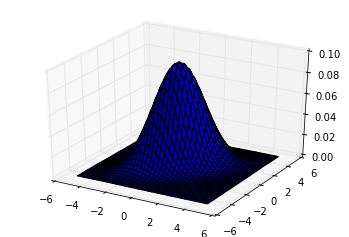

In [31]:
ax = plt.axes(projection='3d')

ax.plot_surface(datax, datay, \
                np.array([multidiml(el,0,covmat) for el in xy.reshape(datax.size,2)]).reshape(datax.shape));


In [68]:
#If you are curious about those eigenvalues and eigenvectors...

print('eigv, eigvec', np.linalg.eig(covmat))

eigv, eigvec (array([3.2, 0.8]), array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]]))


Let's also update our priors to multidim!

In [33]:
def multidim_ln_priors(x, xlo, xhi): #These are flat and proper (limited)
    if np.all([xlo[i] <= x[i] <= xhi[i] for i in range(len(x))]): #lousy implementation
        return 0
    else:
        return -np.inf

And finally, let's combine them in a multi-dim posterior:

In [ ]:
# Sorry, too lazy. But it's probably a good idea.

#### Problem 4: a 2D MCMC sampler

Let's write a 2D MCMC sampler using the above Gaussian likelihood function with mean = [0,0] and covmat = np.array([[2.0,1.2],[1.2, 2.0]]), using as proposal density the 2D identity matrix, flat priors in all parameters between the range of [-10,10]. Let's also keep track of acceptance rate.






















In [34]:
x = np.array([0,0])
accept = 0
nsteps = 10000
ndim = 2
samples = np.zeros([nsteps,ndim])
mu = np.array([0,0])
for n in range(nsteps):
    rando = np.random.rand()
    y = np.random.multivariate_normal(x, np.identity(2), 1).flatten()
    py = multidimlnl(y, mu, covmat) + multidim_ln_priors(y, [-10,-10], [10,10])
    px = multidimlnl(x, mu, covmat) + multidim_ln_priors(x, [-10,-10], [10,10])
    if py - px > np.log(rando):
        samples[n,:] = y
        x = y
        accept+=1
    else:
        samples[n,:] = x
print('accept % =', accept/len(samples))

accept % = 0.6069


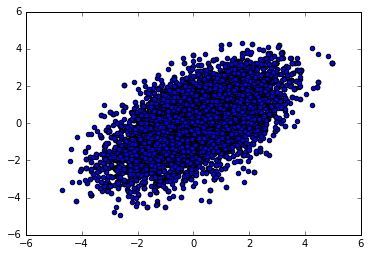

In [35]:
plt.scatter(samples[:,0],samples[:,1]);

### Sanity checks!

1\. Let's see what happens if we make the likelihood very small (raising it to a tiny power, i.e. multiplying log like by a small number). What do we expect? A: To find the priors :) 

In [36]:
x = np.array([0,0])
accept = 0
nsteps = 10000
ndim = 2
samples = np.zeros([nsteps,ndim])
mu = np.array([0,0])
for n in range(nsteps):
    rando = np.random.rand()
    y = np.random.multivariate_normal(x, np.identity(2), 1).flatten()
    py = 0.01*multidimlnl(y, mu, covmat) + multidim_ln_priors(y, [-10,-10], [10,10])
    px = 0.01*multidimlnl(x, mu, covmat) + multidim_ln_priors(x, [-10,-10], [10,10])
    if py - px > np.log(rando):
        samples[n,:] = y
        x = y
        accept+=1
    else:
        samples[n,:] = x
print('accept % =', accept/len(samples))

accept % = 0.9239


In [ ]:
plt.hist(np.array(samples)[:,0],bins=50,alpha = 0.5, histtype='stepfilled');
plt.hist(np.array(samples)[:,1],bins=50,alpha = 0.5,histtype='stepfilled');

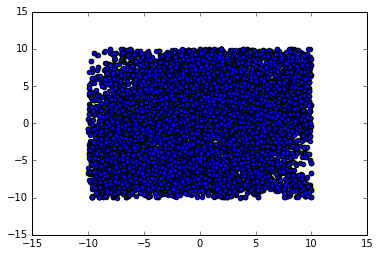

In [37]:
plt.scatter(np.array(samples)[:,0],np.array(samples)[:,1])

2\. Let's see what happens when we make the proposal density very small, or very big. What do we expect? A: Larger proposal density implies higher mobility and lower acceptance rates. Smaller proposal density reduces mobility, increases acceptance rates.



In [40]:
x = np.array([0,0])
accept = 0
nsteps = 10000
ndim = 2
samples = np.zeros([nsteps,ndim])
mu = np.array([0,0])
for n in range(nsteps):
    rando = np.random.rand()
    y = np.random.multivariate_normal(x, 3*np.identity(2), 1).flatten()
    py = multidimlnl(y, mu, covmat) + multidim_ln_priors(y, [-10,-10], [10,10])
    px = multidimlnl(x, mu, covmat) + multidim_ln_priors(x, [-10,-10], [10,10])
    if py - px > np.log(rando):
        samples[n,:] = y
        x = y
        accept+=1
    else:
        samples[n,:] = x
print('accept % =', accept/len(samples))

accept % = 0.4096


Usually, I want my acceptance rate to be between 25-50%.

3\. Let's plot the first parameter of the chain versus the steps to see the sampled values. What do we expect? A: We like to see the parameters traverse their parameter space several times, as opposed to being "stuck" in one location.

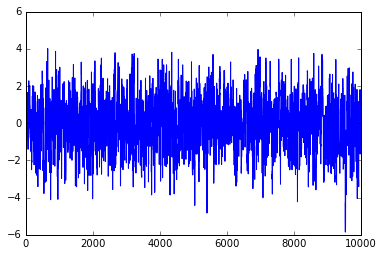

In [41]:
plt.plot(range(len(samples[:,0])),samples[:,0])

### Convergence 

Main idea: do results change if I keep running the chain(s)?

Can do a couple of things: look at different quantiles of a chain and see if there are significant differences, or running multiple chains. 

In [ ]:
print(np.mean(samples[:int(0.25*nsteps),0]), np.std(samples[:int(0.25*nsteps),0]))

In [ ]:
print(np.mean(samples[int(0.25*nsteps):int(0.5*nsteps),0]), np.std(samples[int(0.25*nsteps):int(0.5*nsteps),0]))

In [42]:
def chain_stats(chain, nsplits = 4, plot = True):
###  ###
    nsteps = chain.shape[0]
    means = np.array([np.mean(chain[int(i*nsteps/nsplits):int((i+1)*nsteps/nsplits)],axis=0) \
                      for i in range(nsplits)])
    stds = np.array([np.std(chain[int(i*nsteps/nsplits):int((i+1)*nsteps/nsplits)],axis=0) \
                     for i in range(nsplits)])
    
    if plot == True:
        for j in range(chain.shape[1]):
            ax = plt.gca()
            ax.set_xlim(-0.5,nsplits-0.5)
            plt.errorbar(range(nsplits), means[:,j], fmt='s', yerr = stds[:,j], \
                         label ='parameter '+ str(j))
        plt.legend(numpoints=1)
    return means, stds

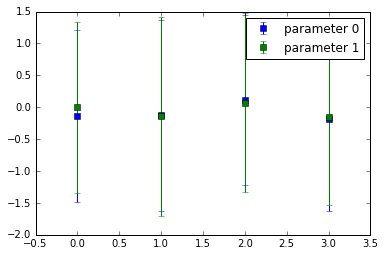

In [43]:
means, stds = chain_stats(samples)

### Results! Find mean, mode, 68% and 95% credible intervals for the two parameters

In [44]:
for i in range(samples.shape[1]):
    print('Median, 68% interval',"{:.4f}  {:.4f}  {:.4f}".format(np.percentile(samples[:,i],50),np.percentile(samples[:,i],16),np.percentile(samples[:,i],84)))
    print('95% interval',"{:.4f}  {:.4f}".format(np.percentile(samples[:,i],2.5),np.percentile(samples[:,i],97.5)))

Median, 68% interval -0.1085  -1.4856  1.3150
95% interval -2.8002  2.7324
Median, 68% interval -0.0635  -1.4985  1.3692
95% interval -2.9231  2.6962


### Next up: running multiple chains

In [45]:
#This is poorly written because I am not passing the posterior as an argument of the function,
#And for many other reasons I am sure. Be gentle.

def runchains(nchains = 4, ndim = 2, init = [], nsteps = 10000):
    if init.all is None:
        init = np.zeros(ndim,nchains)
    samples = np.zeros([nsteps,ndim,nchains])
    mu = np.zeros(ndim)
    for chain in range(nchains):
        x = init[:,chain]
        accept = 0
        for n in range(nsteps):
            rando = np.random.rand()
            y = np.random.multivariate_normal(x, np.identity(ndim), 1).flatten()
            py = multidimlnl(y, mu, covmat) + multidim_ln_priors(y, [-10,-10], [10,10])
            px = multidimlnl(x, mu, covmat) + multidim_ln_priors(x, [-10,-10], [10,10])
            if py - px > np.log(rando):
                x = y
                accept+=1
            samples[n,:,chain] = x
        print('accept % =', accept/nsteps*100)
    return samples

In [46]:
newsamples = runchains(init = np.array([[0,9,-1,3],[0,9,-2,2]]),nsteps=10000)

accept % = 60.419999999999995
accept % = 61.3
accept % = 60.73
accept % = 61.050000000000004


We can take a look at the impact of initial point:

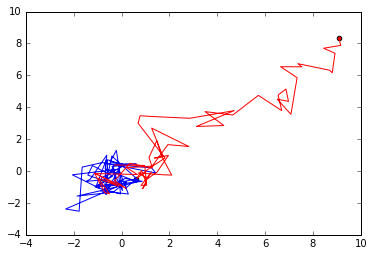

In [47]:
plt.plot(newsamples[:100,0,0],newsamples[:100,1,0])
plt.scatter(newsamples[0,0,0],newsamples[0,1,0])
plt.plot(newsamples[:100,0,1],newsamples[:100,1,1], c = 'red')
plt.scatter(newsamples[0,0,1],newsamples[0,1,1], c = 'red')

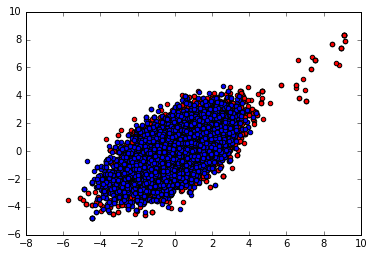

In [48]:
plt.scatter(newsamples[:,0,1],newsamples[:,1,1], c = 'red')
plt.scatter(newsamples[:,0,0],newsamples[:,1,0], c = 'blue')

And look at the whether the parameter estimates vary across chains (convergence test):

In [49]:
for i in range(newsamples.shape[2]): #loop over chains for param 1
    print('Median',"{:.4f}".format(np.percentile(newsamples[:,0,i],50))) 
    print('68% interval',"{:.4f}  {:.4f}".format(np.percentile(newsamples[:,0,i],16),np.percentile(newsamples[:,0,i],84)))
    print('95% interval',"{:.4f}  {:.4f}".format(np.percentile(newsamples[:,0,i],2.5),np.percentile(newsamples[:,0,i],97.5)))

Median -0.0488
68% interval -1.4766  1.2946
95% interval -2.9463  2.6777
Median 0.1337
68% interval -1.3278  1.5438
95% interval -2.6398  2.8993
Median -0.0348
68% interval -1.4547  1.5019
95% interval -2.9793  3.0114
Median -0.0125
68% interval -1.3751  1.3829
95% interval -2.6624  2.8724


### Measuring efficiency: Auto correlation time

One of the characteristics of the samples we'd like to collect is that they are independent of one other (uncorrelated). However, in a typical chain, nearby steps will be correlated. We can get an idea of how separated steps should be by plotting the auto-correlation function of the chain as a function of separation.

In [50]:
#https://ipython-books.github.io/103-computing-the-autocorrelation-of-a-time-series/

def autocorr(x, norm = True):
    result = np.correlate(x, x, mode='full')
    result = result[result.size // 2:] #starts symmetric around 0 so take second part
    if norm:
        return result/result[0] 
    else: 
        return result

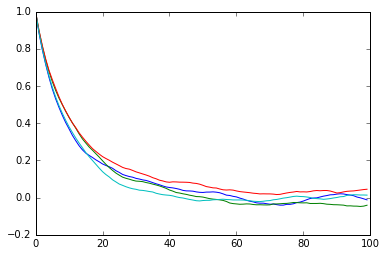

In [51]:
#Autocorr time for parameter 1, for each of the chains:

for i in range(newsamples.shape[2]):
    plt.plot(range(100),autocorr(newsamples[:,1,i])[:100])

In [55]:
#This seems to work

emcee.autocorr.integrated_time(newsamples[:,1,3], low=10, high=None, step=1, c=10, full_output=False, axis=0, fast=False)

/Users/vivi/anaconda/lib/python3.4/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


16.794403804455964

As a general rule, a chain should run with N >> tau samples, where tau is the autocorrelation time, because the expected error (mismatch between real distribution and samples) scales like sqrt(tau/N). Small autocorrelation times imply faster convergence.

At zero order, one can play around with acceptance rate to affect the autocorrelation time.

More info:

https://dfm.io/posts/autocorr/

#### Final bit: Can I break Metropolis-Hastings?

Let's model a double-peaked distribution, in 1D to keep things simple.

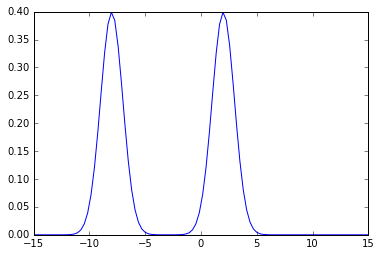

In [56]:
v = np.linspace(-15,15,100)
plt.plot(v,l(v,2,1)+l(v,-8,1))

In [62]:
def runchains(nchains = 4, ndim = 2, init = None, nsteps = 10000):
    if init is None:
        init = np.zeros([ndim,nchains])
    samples = np.zeros([nsteps,ndim,nchains])
    mu = np.zeros(ndim)
    for chain in range(nchains):
        x = init[:,chain]
        accept = 0
        for n in range(nsteps):
            rando = np.random.rand()
            y = np.random.multivariate_normal(x, 5*np.identity(ndim), 1).flatten()
            py = np.log(l(y, -8, 1) + l(y, 2, 1)) + multidim_ln_priors(y, [-20], [20])
            px = np.log(l(x, -8, 1) + l(x, 2, 1)) + multidim_ln_priors(x, [-20], [20])
            if py - px > np.log(rando):
                x = y
                accept+=1
            samples[n,:,chain] = x
        print('accept % =', accept/nsteps*100)
    return samples

In [63]:
newsamples = runchains(ndim=1, init = np.array([[0,-9,-9,3]]))

accept % = 46.31
accept % = 46.37
accept % = 46.53
accept % = 47.15


We can look at the distribution.

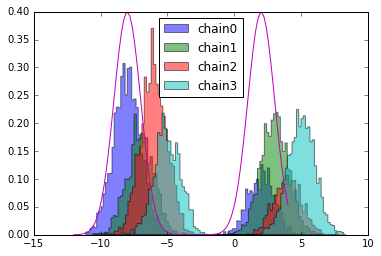

In [64]:
for i in range(newsamples.shape[2]):
    plt.hist(newsamples[:,0,i]+i,bins=100,normed=True,histtype='stepfilled',alpha = 0.5, label = 'chain'+str(i));
plt.legend(loc='upper center')
points = np.linspace(-12,4,100)
plt.plot(points,l(points,-8,1)+l(points,2,1))

And some of the derived statistics.

In [65]:
for i in range(newsamples.shape[2]): #loop over chains
    print('Median, 68% interval',"{:.4f}  {:.4f}  {:.4f}".format(np.percentile(newsamples[:,0,i],50),np.percentile(newsamples[:,0,i],16),np.percentile(newsamples[:,0,i],84)))
#    print('95% interval',"{:.4f}  {:.4f}".format(np.percentile(newsamples[:,0,i],2.5),np.percentile(newsamples[:,0,i],97.5)))

Median, 68% interval -7.5281  -8.7828  1.8095
Median, 68% interval 0.5057  -8.3835  2.5330
Median, 68% interval -7.5859  -8.7730  1.6415
Median, 68% interval 0.5211  -8.4133  2.5638


Note the dependence on initial position, proposal density.

#### If you suspect that your posterior looks like this, M-H may struggle to give meaningful results. In this case, the chains either get stuck in one location, or (with proper mixing) they discover the two peaks, but it's clear that the density of visited locations is not correctly replicating the volume of the posterior. Luckily, in most cases you will notice that something is amiss (chains have not converged).

Can try more sophisticated algorithms such as emcee and nested sampling.